In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch] # convert char to index
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80% 
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [7]:
max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # sample random row indices
    Xb, Yb = Xtr[ix], Ytr[ix]   # batch X,Y of char indices 

    # Forward pass
    emb = C[Xb]                             # embed the characters into vectors
    emb_cat = emb.view(emb.shape[0], -1)    # concatenate the vectors
    h_pre_act = emb_cat @ W1 + b1           # hidden layer pre-activation
    h = torch.tanh(h_pre_act)               # hidden layer
    logits = h @ W2 + b2                    # output layer    
    loss = F.cross_entropy(logits, Yb)      # loss function
    
    # Backward pass
    for p in parameters:    
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters: # Note that the embeddings are also updated!
        p.data += -lr * p.grad

    # Track stats
    if i  % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item()) 

      0/ 200000: 27.8817
  10000/ 200000: 2.7955
  20000/ 200000: 2.6306
  30000/ 200000: 2.8458
  40000/ 200000: 2.0263
  50000/ 200000: 2.5424
  60000/ 200000: 2.3461
  70000/ 200000: 2.1167
  80000/ 200000: 2.3299
  90000/ 200000: 2.2775
 100000/ 200000: 2.0110
 110000/ 200000: 2.2857
 120000/ 200000: 1.8496
 130000/ 200000: 2.3583
 140000/ 200000: 2.1619
 150000/ 200000: 2.2178
 160000/ 200000: 2.0732
 170000/ 200000: 1.7830
 180000/ 200000: 1.9616
 190000/ 200000: 1.9436


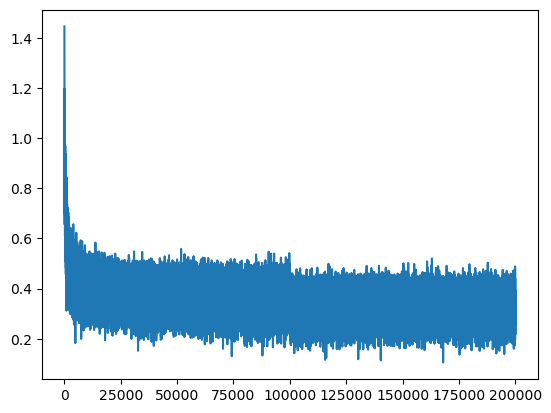

In [8]:
plt.plot(loss_i)

In [9]:
@torch.no_grad()    # temporarily turns off gradient computation for the next function
                    # Makes the code more efficient since Pytorch does not have to maintain the computational graph for gradient calc

def split_loss(split: str) -> None:
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # index into the dictionary to select what to evaluate based on function call

    #Forward pass
    emb = C[x]                              # (N, block_size, n_embd)                        
    emb_cat = emb.view(emb.shape[0], -1)    # concat into (N, block_size * n_embd)
    h = torch.tanh(emb_cat @ W1 + b1)       # (N, n_hidden)
    logits = h @ W2 + b2                    # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1277637481689453
val 2.1674869060516357


In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d) because it's 1 example being generated, every forward pass adds a prediction until . is hit
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() # sample from predicted probability distribution over the characters
      context = context[1:] + [ix] # shift context
      out.append(ix) # append index of predicted character
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # convert indices to characters and print

mona.
mayah.
seel.
nah.
yal.
rener.
jendraegustered.
eliia.
milopaleigh.
eson.
arleitzion.
kamin.
shubergian.
jest.
jair.
jenslen.
profio.
zey.
der.
yarue.


In [11]:
# Issues: 

# 1) The loss at initialization is not appropriate:
#    first 10k training steps loss:
#                     0/ 200000: 27.8817
#                     10000/ 200000: 2.7955
# 
#  We expect the model to predict all characters with equal probability when it hasn't learned
#  anything yet. This means a p of 1/27.0. And the associated loss is:
print(f'{-torch.tensor(1/27.0).log() = }')

# Note: if instead we correctly initialize the weights (around 0 but with some entropy to break symmetry) and biases (to 0),
#       the first 10k iterations can be used to actually learn something, yielding better performance of the NN after all training is done.

# 2) if too many activations fed into the tanh are too large, the tanh will respond in the same way (with -1 or 1, remember tanh graph), 
#    this causes gradients to vanish, which can result in dead neurons that never learn (their weights and biases are never learning)! 
#       Remember summary of grad calc Steps:
#           Compute the forward pass with y = tanh(x).
#           During backpropagation, receive the gradient of the loss with respect to the output of the tanh function, dL/dy.
#           Compute the derivative of the tanh function: dy/dx = 1 - tanh^2(x) = 1 - y^2.
#           Apply the chain rule: dL/dx = dL/dy * (1 - y^2).
#    https://www.youtube.com/watch?v=P6sfmUTpUmc&t=144s (00:12:59 - 00:27:53)

-torch.tensor(1/27.0).log() = tensor(3.2958)


### Distributions optimization

In [12]:
# Initialize
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [13]:
max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # sample random row indices
    Xb, Yb = Xtr[ix], Ytr[ix]   # batch X,Y of char indices 

    # Forward pass
    emb = C[Xb]                             # embed the characters into vectors
    emb_cat = emb.view(emb.shape[0], -1)    # concatenate the vectors
    h_pre_act = emb_cat @ W1 + b1           # hidden layer pre-activation
    h = torch.tanh(h_pre_act)               # hidden layer
    logits = h @ W2 + b2                    # output layer    
    loss = F.cross_entropy(logits, Yb)      # loss function
    
    # Backward pass
    for p in parameters:    
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters: # Note that the embeddings are also updated!
        p.data += -lr * p.grad

    # Track stats
    if i  % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item()) 

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


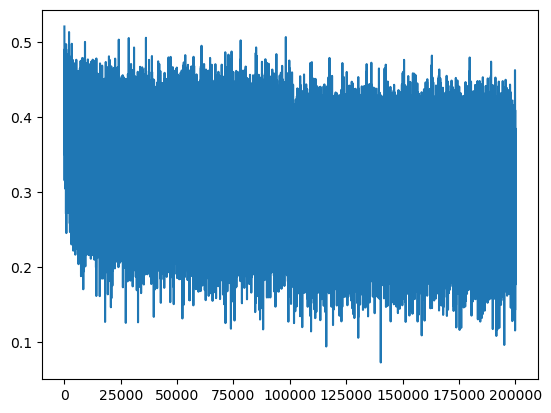

In [14]:
plt.plot(loss_i)

In [15]:
@torch.no_grad()    # temporarily turns off gradient computation for the next function
                    # Makes the code more efficient since Pytorch does not have to maintain the computational graph for gradient calc

def split_loss(split: str) -> None:
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # index into the dictionary to select what to evaluate based on function call

    #Forward pass
    emb = C[x]                              # (N, block_size, n_embd)                        
    emb_cat = emb.view(emb.shape[0], -1)    # concat into (N, block_size * n_embd)
    h = torch.tanh(emb_cat @ W1 + b1)       # (N, n_hidden)
    logits = h @ W2 + b2                    # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

# Note: Loss is much better.

train 2.0355966091156006
val 2.1026785373687744
